In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
training_set_labels = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/training_set_labels.csv')
training_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/traning_set_values.csv')
test_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/test_set_values.csv')

# Merge
Train_df = pd.merge(training_set_values, training_set_labels, on='id')
df = Train_df.copy()

In [ ]:
# @title all else

Numeric columns: ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']
String columns: ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
# @title H2O randomforest
# --------------------------------------------
# Imports and Setup
# --------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Data
training_set_labels = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/training_set_labels.csv')
training_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/traning_set_values.csv')
test_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/test_set_values.csv')

# Merge training data
Train_df = pd.merge(training_set_values, training_set_labels, on='id')
df = Train_df.copy()

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# --------------------------------------
# 🧼 Preprocessing + Label Encoding
# --------------------------------------

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
encoders = {}

def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col] = df[col].fillna("other")  # ✅ FIX: avoids chained assignment warning

    df.fillna(0, inplace=True)
    return df


def build_model_h2o(train_df, data_proportion=1.0, ntrees=300, max_depth=None, seed=42):
    import h2o
    from h2o.estimators.random_forest import H2ORandomForestEstimator

    # Start H2O server
    h2o.init()

    # Preprocess data
    df = clean_encode_label(train_df.copy(), is_train=True)

    if data_proportion < 1.0:
        df, _ = train_test_split(df, train_size=data_proportion, stratify=df['status_group'], random_state=seed)

    target = 'status_group'
    features = [col for col in df.columns if col != target]

    hf = h2o.H2OFrame(df)
    hf[target] = hf[target].asfactor()

    train_h2o, test_h2o = hf.split_frame(ratios=[0.875], seed=seed)

    model = H2ORandomForestEstimator(ntrees=ntrees, max_depth=max_depth, seed=seed)
    model.train(x=features, y=target, training_frame=train_h2o)

    pred = model.predict(test_h2o)
    pred_labels = pred.as_data_frame().iloc[:, 0]
    y_test = test_h2o[target].as_data_frame().iloc[:, 0]

    acc = accuracy_score(y_test, pred_labels)
    print(f"✅ Model accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, pred_labels))

    # cm = confusion_matrix(y_test, pred_labels, labels=model.actual_params['response_column_domain'])
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    #             xticklabels=model.actual_params['response_column_domain'],
    #             yticklabels=model.actual_params['response_column_domain'])
    # plt.xlabel("Predicted")
    # plt.ylabel("Actual")
    # plt.title("Confusion Matrix")
    # plt.show()

    return {
        'model': model,
        'features': features
    }


def predict_test_set_h2o(model_data, test_df):
    import h2o
    model = model_data['model']
    features = model_data['features']

    df_clean = clean_encode_label(test_df.copy(), is_train=False)

    # Ensure all required features exist
    missing_cols = set(features) - set(df_clean.columns)
    for col in missing_cols:
        df_clean[col] = 0

    df_clean = df_clean[features]

    hf_test = h2o.H2OFrame(df_clean)
    predictions = model.predict(hf_test).as_data_frame().iloc[:, 0]

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_h2o_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


# Preprocess full training data
df = clean_encode_label(df, is_train=True)

# ✅ Train model
model_data = build_model_h2o(df,1)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,32 mins 05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_nfq68b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.042 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
✅ Model accuracy: 0.8079
Classification Report:


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      4062
functional needs repair       0.59      0.29      0.39       553
         non functional       0.86      0.76      0.81      2906

               accuracy                           0.81      7521
              macro avg       0.75      0.65      0.68      7521
           weighted avg       0.80      0.81      0.80      7521



In [ ]:
# !pip install -qU "xgboost>=1.3.0"
import xgboost
print(xgboost.__version__)  # Confirm it's ≥1.3.0


2.1.4


In [ ]:
# @title Optuna + XGBoost Full Pipeline (Google Colab Compatible)

# Install required packages
!pip install -q optuna category_encoders xgboost

# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna
from category_encoders import TargetEncoder

# 2. Duplicate & Irrelevant Columns
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# 3. K-Fold Target Encoding

def kfold_target_encoding(train_df, cat_cols, target_col, n_splits=5):
    df = train_df.copy()
    global_mean = df[target_col].mean()

    for col in cat_cols:
        df[col + '_te'] = np.nan
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_idx, valid_idx in skf.split(df, df[target_col]):
            X_train, X_valid = df.iloc[train_idx], df.iloc[valid_idx]
            means = X_train.groupby(col)[target_col].mean()
            df.loc[df.index[valid_idx], col + '_te'] = df.loc[df.index[valid_idx], col].map(means)

        df[col + '_te'].fillna(global_mean, inplace=True)

    return df

# 4. Objective Function (Optuna)
def objective(trial, train_df):
    target_col = 'status_group'
    df = train_df.copy()

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(lambda m: 4 if m in [3,4,5] else 3 if m in [10,11,12] else 2 if m in [1,2] else 1)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if col != target_col:
            df[col].fillna("other", inplace=True)
    df.fillna(0, inplace=True)

    cat_cols = df.select_dtypes(include='object').columns.tolist()

    df_encoded = kfold_target_encoding(df, cat_cols, target_col)
    features = [col for col in df_encoded.columns if col not in cat_cols + [target_col]]

    X = df_encoded[features]
    y = df_encoded[target_col]

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model_type = trial.suggest_categorical("model", ["xgboost", "random_forest"])

    if model_type == "xgboost":
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 50, 300),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
            'max_depth': trial.suggest_int("max_depth", 3, 10),
            'reg_lambda': trial.suggest_float("reg_lambda", 1e-3, 10.0),
            'random_state': 42,
            'use_label_encoder': False,
            'verbosity': 0
        }
        model = XGBClassifier(**params)
    else:
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 50, 300),
            'max_depth': trial.suggest_int("max_depth", 3, 20),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
            'random_state': 42
        }
        model = RandomForestClassifier(**params)

    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    return accuracy

# 5. Main Function to Run Optimization
def optimize_and_train(train_df, n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_df), n_trials=n_trials)

    print("Best trial:")
    print(study.best_trial)

    return study.best_trial

# 6. Example: Load and Run
# df = pd.read_csv("your_dataset.csv")
# best_model = optimize_and_train(df, n_trials=30)


In [ ]:
# [I 2025-05-14 13:12:57,544] Trial 94 finished with value: 0.8125420875420876 and parameters: {'model': 'random_forest', 'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 94 with value: 0.8125420875420876.
optimize_and_train(df,100)

In [ ]:
# @title Hide
# Install required packages
!pip install -q optuna category_encoders xgboost

# 1. Imports
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import optuna

# 2. Duplicate & Irrelevant Columns
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# 3. K-Fold Target Encoding
def kfold_target_encoding(train_df, cat_cols, target_col, n_splits=5):
    df = train_df.copy()
    global_mean = df[target_col].mean()

    for col in cat_cols:
        df[col + '_te'] = np.nan
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_idx, valid_idx in skf.split(df, df[target_col]):
            X_train, X_valid = df.iloc[train_idx], df.iloc[valid_idx]
            means = X_train.groupby(col)[target_col].mean()
            df.loc[df.index[valid_idx], col + '_te'] = df.loc[df.index[valid_idx], col].map(means)

        df[col + '_te'].fillna(global_mean, inplace=True)

    return df

# 4. Objective Function (Optuna)
def objective(trial, train_df):
    target_col = 'status_group'
    df = train_df.copy()

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(lambda m: 4 if m in [3,4,5] else 3 if m in [10,11,12] else 2 if m in [1,2] else 1)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if col != target_col:
            df[col].fillna("other", inplace=True)
    df.fillna(0, inplace=True)

    cat_cols = df.select_dtypes(include='object').columns.tolist()

    df_encoded = kfold_target_encoding(df, cat_cols, target_col)
    features = [col for col in df_encoded.columns if col not in cat_cols + [target_col]]

    X = df_encoded[features]
    y = df_encoded[target_col]

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    params = {
        'n_estimators': trial.suggest_int("n_estimators", 50, 300),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-3, 10.0),
        'random_state': 42,
        'use_label_encoder': False,
        'verbosity': 0
    }
    model = XGBClassifier(**params)

    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    return accuracy

# 5. Main Function to Run Optimization
def optimize_and_train(train_df, n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_df), n_trials=n_trials)

    print("Best trial:")
    print(study.best_trial)

    return study.best_trial

# 6. Predict on Test Set Using Best Trial
def predict_test_set_label_optuna(best_trial, train_df, test_df):
    target_col = 'status_group'

    df = train_df.copy()
    test = test_df.copy()

    if 'date_recorded' in test.columns:
        test['date_recorded'] = pd.to_datetime(test['date_recorded'])
        test['raininess_score'] = test['date_recorded'].dt.month.apply(lambda m: 4 if m in [3,4,5] else 3 if m in [10,11,12] else 2 if m in [1,2] else 1)

    test = test.drop(columns=[col for col in crossed_out_columns if col in test.columns], errors='ignore')
    for col in test.select_dtypes(include='object').columns:
        test[col].fillna("other", inplace=True)
    test.fillna(0, inplace=True)

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(lambda m: 4 if m in [3,4,5] else 3 if m in [10,11,12] else 2 if m in [1,2] else 1)
    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')
    for col in df.select_dtypes(include='object').columns:
        if col != target_col:
            df[col].fillna("other", inplace=True)
    df.fillna(0, inplace=True)

    cat_cols = df.select_dtypes(include='object').columns.tolist()
    df_encoded = kfold_target_encoding(df, cat_cols, target_col)
    means_dict = {}
    for col in cat_cols:
        means_dict[col] = df.groupby(col)[target_col].mean()
        test[col + '_te'] = test[col].map(means_dict[col]).fillna(df[target_col].mean())

    features = [col for col in df_encoded.columns if col not in cat_cols + [target_col]]
    X_train = df_encoded[features]
    y_train = df_encoded[target_col]
    X_test = test[features]

    model = XGBClassifier(
        n_estimators=best_trial.params['n_estimators'],
        learning_rate=best_trial.params['learning_rate'],
        max_depth=best_trial.params['max_depth'],
        reg_lambda=best_trial.params['reg_lambda'],
        random_state=42,
        use_label_encoder=False,
        verbosity=0
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': preds
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"optuna_predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df

# 7. Example: Load and Run
# df = pd.read_csv("your_dataset.csv")
# test_df = pd.read_csv("your_test_set.csv")
# best_model = optimize_and_train(df, n_trials=30)
# result = predict_test_set_label_optuna(best_model, df, test_df)

In [ ]:
# @title label_encode with all the datapoints

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -----------------------------------------------
# Columns to drop
# -----------------------------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------------------------
# 1. Preprocessing + Label Encoding
# -----------------------------------------------

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
encoders = {}

def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("other", inplace=True)

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------------------------
# 2. Train Full Model on All Data (no split)
# -----------------------------------------------

def train_full_model(train_df, n_estimators=400, max_depth=None, random_state=42):
    train_df = clean_encode_label(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X, y)

    # Predict on same data
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)

    print("✅ Model trained on 100% of training data.")
    print(f"🧪 Accuracy on training data: {acc:.4f}")
    print("📄 Classification Report:")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Training Data)")
    plt.show()

    return {
        'model': model
    }

# -----------------------------------------------
# 3. Predict on Test Set + Save
# -----------------------------------------------

def predict_test_set_label(model_data, test_df):
    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df



<ipython-input-25-d1158828b89b>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)


✅ Model trained on 100% of training data.
🧪 Accuracy on training data: 1.0000
📄 Classification Report:
                         precision    recall  f1-score   support

             functional       1.00      1.00      1.00     32259
functional needs repair       1.00      1.00      1.00      4317
         non functional       1.00      1.00      1.00     22824

               accuracy                           1.00     59400
              macro avg       1.00      1.00      1.00     59400
           weighted avg       1.00      1.00      1.00     59400



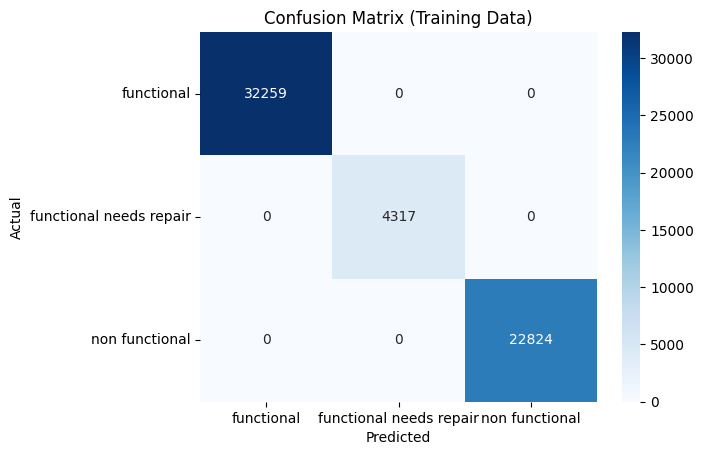

In [ ]:
model_data = train_full_model(Train_df)

In [ ]:
predict_test_set_label(model_data, test_set_values)

<ipython-input-25-d1158828b89b>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)


✅ Saved 14850 predictions to predictions_2025-05-14_17-47-22.csv


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [ ]:
# @title xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# -----------------------------------------------
# Columns to drop
# -----------------------------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------------------------
# 1. Preprocessing + Label Encoding
# -----------------------------------------------
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
encoders = {}
target_encoder = LabelEncoder()  # Global target label encoder

def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col] = df[col].fillna("other")

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------------------------
# 2. Train Model with Train/Test Split (Validation)
# -----------------------------------------------
def train_with_split(train_df, test_size=0.2, random_state=42):
    global target_encoder

    df = clean_encode_label(train_df, is_train=True)
    y = target_encoder.fit_transform(df['status_group'])
    X = df.drop(columns=['status_group'])

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        random_state=random_state,
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        n_jobs=-1,
        eval_metric='mlogloss'
    )

    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    print("✅ XGBoost trained with train/test split.")
    print(f"🧪 Accuracy on validation data: {acc:.4f}")
    print("📄 Classification Report:")
    print(classification_report(y_val, y_pred, target_names=target_encoder.classes_))

    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Validation Set)")
    plt.show()

    return {
        'model': model
    }

# -----------------------------------------------
# 3. Predict on Test Set + Save
# -----------------------------------------------
def predict_test_set_label(model_data, test_df):
    global target_encoder

    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)
    decoded_preds = target_encoder.inverse_transform(predictions)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': decoded_preds
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


✅ XGBoost trained with train/test split.
🧪 Accuracy on validation data: 0.8056
📄 Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      6457
functional needs repair       0.53      0.31      0.39       851
         non functional       0.84      0.77      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.73      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



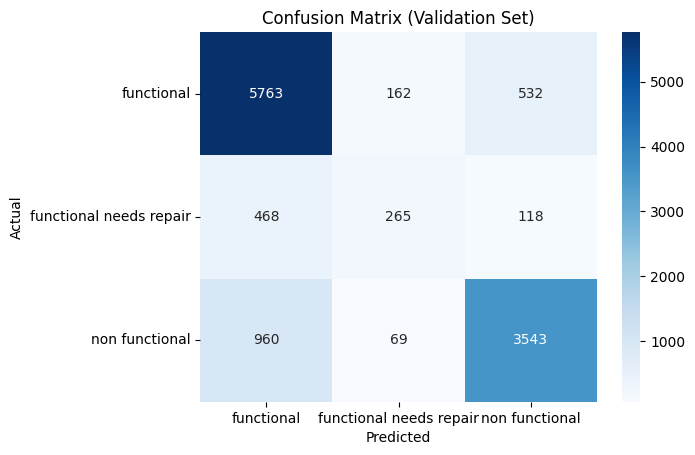

In [ ]:
model = train_with_split(Train_df)

In [ ]:
# @title XGBoost + Optuna with train/validation split evaluation

!pip install optuna

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import optuna

# -----------------------------------------------
# Columns to drop
# -----------------------------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------------------------
# 1. Preprocessing + Label Encoding
# -----------------------------------------------

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
encoders = {}
target_encoder = LabelEncoder()  # Global target label encoder

def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col] = df[col].fillna("other")  # Fix FutureWarning

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                # Replace unseen labels with the first known class
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------------------------
# 2. Objective function for Optuna tuning
# -----------------------------------------------

def objective(trial, X_train, y_train, X_valid, y_valid):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'random_state': 42,
    }

    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    return acc

# -----------------------------------------------
# 3. Train with train-test split and Optuna
# -----------------------------------------------

def train_full_model(train_df, test_size=0.2, random_state=42, n_trials=50):
    global target_encoder

    # Preprocess & encode train data
    train_df = clean_encode_label(train_df, is_train=True)
    y = target_encoder.fit_transform(train_df['status_group'])
    X = train_df.drop(columns=['status_group'])

    # Split train/validation
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Optuna study
    def optuna_objective(trial):
        return objective(trial, X_train, y_train, X_valid, y_valid)

    study = optuna.create_study(direction='maximize')
    study.optimize(optuna_objective, n_trials=n_trials)

    print("Best hyperparameters:", study.best_params)

    # Train final model on full train data with best params
    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y)),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'random_state': random_state,
    })

    model = XGBClassifier(**best_params)
    model.fit(X, y)

    # Evaluate on validation set
    y_valid_pred = model.predict(X_valid)
    acc_valid = accuracy_score(y_valid, y_valid_pred)

    print(f"✅ XGBoost model trained with Optuna best params.")
    print(f"🧪 Accuracy on validation data: {acc_valid:.4f}")
    print("📄 Classification Report (Validation):")
    print(classification_report(y_valid, y_valid_pred, target_names=target_encoder.classes_))

    cm = confusion_matrix(y_valid, y_valid_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Validation Data)")
    plt.show()

    return {
        'model': model,
        'best_params': best_params
    }

# -----------------------------------------------
# 4. Predict on Test Set + Save
# -----------------------------------------------

def predict_test_set_label(model_data, test_df):
    global target_encoder

    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)
    decoded_preds = target_encoder.inverse_transform(predictions)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': decoded_preds
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


[I 2025-05-15 06:10:14,384] A new study created in memory with name: no-name-e13e6ab1-6423-498b-80f9-32fb5634b7c1
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:10:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-15 06:11:13,726] Trial 0 finished with value: 0.7758417508417509 and parameters: {'n_estimators': 591, 'max_depth': 10, 'learning_rate': 0.03144667998131769, 'subsample': 0.5868943186271429, 'colsample_bytree': 0.9628464127472081, 'gamma': 4.863433347803758, 'min_child_weight': 7}. Best is trial 0 with value: 0.7758417508417509.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:11:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-15 06:11:40,512] Trial 1 finished with value: 0.7927609427609428 and parameters: {'n_estimators': 426, 'max_d

Best hyperparameters: {'n_estimators': 946, 'max_depth': 14, 'learning_rate': 0.030815625709339205, 'subsample': 0.831394333999109, 'colsample_bytree': 0.5421293482872281, 'gamma': 0.7422301232860327, 'min_child_weight': 1}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:11:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost model trained with Optuna best params.
🧪 Accuracy on validation data: 0.9246
📄 Classification Report (Validation):
                         precision    recall  f1-score   support

             functional       0.90      0.98      0.94      6452
functional needs repair       0.93      0.61      0.74       863
         non functional       0.96      0.91      0.93      4565

               accuracy                           0.92     11880
              macro avg       0.93      0.83      0.87     11880
           weighted avg       0.93      0.92      0.92     11880



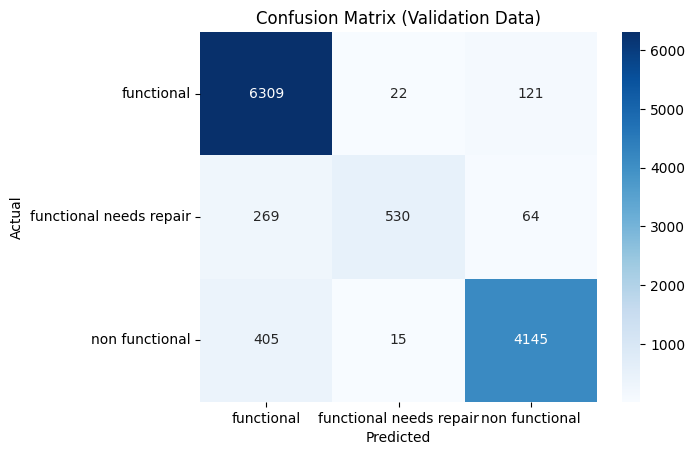

In [ ]:
# Train with Optuna hyperparameter tuning

model_data = train_full_model(Train_df, test_size=0.2, n_trials=100)

# Predict on test data (e.g. Test_df)
#predictions_df = predict_test_set_label(model_data, Test_df)


#best till now
# [I 2025-05-15 05:59:22,030] Trial 0 finished with value: 0.8296506734006734 and parameters: {'n_estimators': 702, 'max_depth': 14, 'learning_rate': 0.02607979639728097, 'subsample': 0.6102133407162929, 'colsample_bytree': 0.832122745377563, 'gamma': 2.8118306413965053, 'min_child_weight': 1}. Best is trial 0 with value: 0.8296506734006734.
# /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:59:22] WARNING: /workspace/src/learner.cc:740:
# Parameters: { "use_label_encoder" } are not used.

[I 2025-05-15 07:12:18,219] A new study created in memory with name: no-name-77a72e54-4da1-46da-b2e2-dfc2d18a86d4
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:12:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-15 07:12:50,420] Trial 0 finished with value: 0.7974747474747474 and parameters: {'n_estimators': 252, 'max_depth': 12, 'learning_rate': 0.013097178474585401, 'subsample': 0.772946578586883, 'colsample_bytree': 0.9454141889818328, 'gamma': 1.591821263176823, 'min_child_weight': 2}. Best is trial 0 with value: 0.7974747474747474.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:12:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-15 07:12:53,959] Trial 1 finished with value: 0.7762626262626262 and parameters: {'n_estimators': 146, 'max_d

Best hyperparameters: {'n_estimators': 429, 'max_depth': 12, 'learning_rate': 0.03798881737889547, 'subsample': 0.9288366778704121, 'colsample_bytree': 0.7196302475452969, 'gamma': 0.6351866874902286, 'min_child_weight': 5}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:03:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost model trained with Optuna best params.
🧪 Accuracy on validation data: 0.8981
📄 Classification Report (Validation):
                         precision    recall  f1-score   support

             functional       0.87      0.97      0.92      6452
functional needs repair       0.89      0.48      0.62       863
         non functional       0.94      0.88      0.91      4565

               accuracy                           0.90     11880
              macro avg       0.90      0.77      0.82     11880
           weighted avg       0.90      0.90      0.89     11880



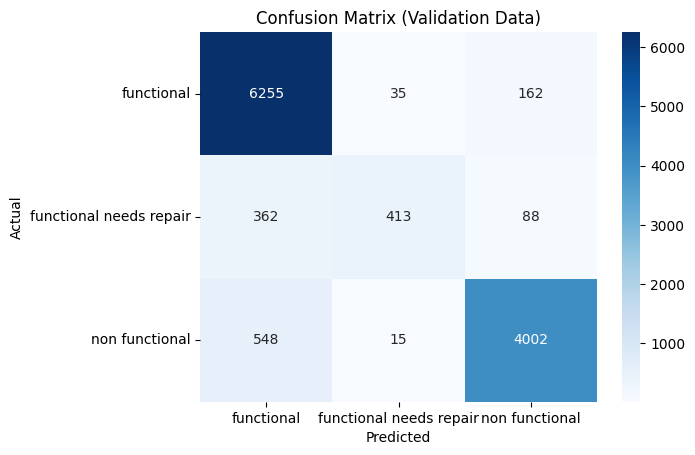

In [ ]:
# [I 2025-05-15 06:04:54,672] Trial 15 finished with value: 0.8784301346801346 and parameters: {'n_estimators': 306, 'max_depth': 10, 'learning_rate': 0.03556957976389411, 'subsample': 0.9746521757009952, 'colsample_bytree': 0.863753278572034, 'gamma': 0.6027626052946664, 'min_child_weight': 3}. Best is trial 15 with value: 0.8784301346801346.

model_data = train_full_model(Train_df, test_size=0.2, n_trials=150)


---

 The above two code blocks perform hyperparameter optimization using an 80-20 split, but the final model is trained on the entire dataset. It is then evaluated on the same 20% validation set. This approach ensures that the model is trained with the maximum possible data. But we can see that it didnt do well even on data that it has been previous trained on.(0.92 and 0.89 accuracy). It should have been 100%, whicch is usually the case for other tree based approach when they are given data they have already been trained on.

---

In [ ]:
# @title XGBoost with 80/20 Split and Optuna Trial 70 Parameters
#[I 2025-05-15 06:47:19,785] Trial 70 finished with value: 0.8112794612794613 and parameters: {'n_estimators': 946, 'max_depth': 14, 'learning_rate': 0.030815625709339205, 'subsample': 0.831394333999109, 'colsample_bytree': 0.5421293482872281, 'gamma': 0.7422301232860327, 'min_child_weight': 1}. Best is trial 70 with value: 0.8112794612794613.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# -----------------------------------------------
# Columns to drop
# -----------------------------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality', 'scheme_name',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------------------------
# Preprocessing + Label Encoding
# -----------------------------------------------

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
encoders = {}
target_encoder = LabelEncoder()  # Global target label encoder

def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col] = df[col].fillna("other")

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------------------------
# Train Model with Optuna Best Params + 80/20 Split
# -----------------------------------------------

def train_with_optuna_params(train_df,
                              test_size=0.2,
                              random_state=42):
    global target_encoder

    train_df = clean_encode_label(train_df, is_train=True)
    y = target_encoder.fit_transform(train_df['status_group'])
    X = train_df.drop(columns=['status_group'])

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Best params from Optuna trial 70
    best_params = {
        'n_estimators': 946,
        'max_depth': 14,
        'learning_rate': 0.030815625709339205,
        'subsample': 0.831394333999109,
        'colsample_bytree': 0.5421293482872281,
        'gamma': 0.7422301232860327,
        'min_child_weight': 1,
        'random_state': random_state,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y)),
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    model = XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)

    print("XGBoost trained using Optuna best params (80/20 split).")
    print(f"Accuracy on test: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_valid, y_pred, target_names=target_encoder.classes_))

    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Validation Data)")
    plt.show()

    return {'model': model}

# -----------------------------------------------
# Predict on Test Set + Save
# -----------------------------------------------

def predict_test_set_label(model_data, test_df):
    global target_encoder

    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)
    decoded_preds = target_encoder.inverse_transform(predictions)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': decoded_preds
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:13:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost trained using Optuna best params (80/20 split).
Accuracy on test: 0.8098
Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.62      0.26      0.37       863
         non functional       0.85      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



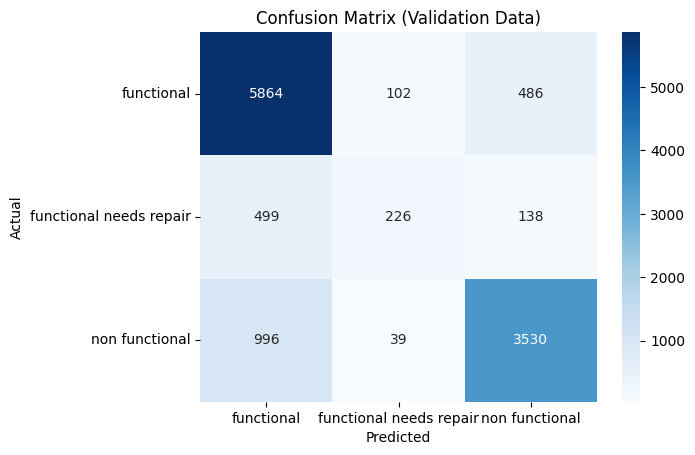

In [ ]:
model_data = train_with_optuna_params(df)
